# STEP 1: DATA LOADING AND UNDERSTANDING

### important packages

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import balanced_accuracy_score,roc_auc_score, confusion_matrix, classification_report, accuracy_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# https://www.datacamp.com/datalab/templates/template-python-resample-a-dataset

In [65]:
# READ DATA
train = pd.read_csv("train.csv")

In [66]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   id                          200000 non-null  int64  
 1   taxi_id                     200000 non-null  object 
 2   trip_start_timestamp        200000 non-null  object 
 3   trip_end_timestamp          199989 non-null  object 
 4   trip_seconds                199950 non-null  float64
 5   trip_miles                  199989 non-null  float64
 6   pickup_community_area       185515 non-null  float64
 7   dropoff_community_area      180433 non-null  float64
 8   fare                        199980 non-null  float64
 9   tips                        199980 non-null  float64
 10  tolls                       189847 non-null  float64
 11  extras                      199980 non-null  float64
 12  trip_total                  199980 non-null  float64
 13  payment_type  

In [67]:
print(train.isnull().sum()/len(train) *100)

id                            0.0000
taxi_id                       0.0000
trip_start_timestamp          0.0000
trip_end_timestamp            0.0055
trip_seconds                  0.0250
trip_miles                    0.0055
pickup_community_area         7.2425
dropoff_community_area        9.7835
fare                          0.0100
tips                          0.0100
tolls                         5.0765
extras                        0.0100
trip_total                    0.0100
payment_type                  0.0000
company                       0.0000
pickup_centroid_latitude      7.2290
pickup_centroid_longitude     7.2290
dropoff_centroid_latitude     9.4375
dropoff_centroid_longitude    9.4375
dtype: float64


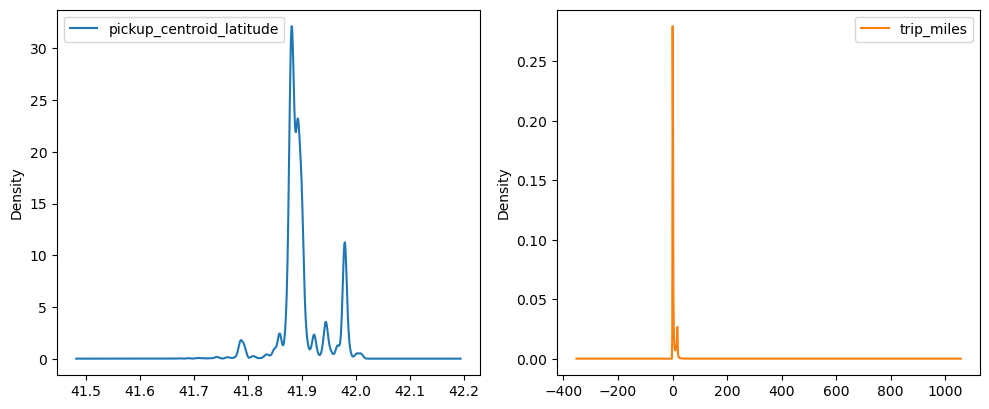

In [68]:
# Specify the columns to plot
columns_to_plot = ['payment_type', 'company', 'pickup_centroid_latitude','trip_miles']  # Replace with your column names

train[columns_to_plot].plot(kind='kde', subplots=True, layout=(2, 2), figsize=(10, 8), sharex=False)
plt.tight_layout()
plt.show()


In [69]:
columns_to_check = ['payment_type', 'company']  # Replace with your column names

for col in columns_to_check:
    if col in train.columns:
        print(f"Value percentages for column: {col}")
        value_counts = train[col].value_counts(normalize=True) * 100
        print(value_counts)
        print("\n")


Value percentages for column: payment_type
payment_type
Cash           49.5825
Credit Card    47.7605
Mobile          1.1625
Prcard          0.6975
Unknown         0.5370
No Charge       0.2095
Dispute         0.0360
Pcard           0.0080
Prepaid         0.0065
Name: proportion, dtype: float64


Value percentages for column: company
company
Taxi Affiliation Services                       19.8215
Flash Cab                                       14.5235
Chicago Carriage Cab Corp                       11.1860
Medallion Leasin                                 7.1660
Sun Taxi                                         7.1025
City Service                                     6.5670
Star North Management LLC                        5.8435
Blue Ribbon Taxi Association Inc.                4.7440
Choice Taxi Association                          3.3520
Taxi Affiliation Service Yellow                  3.2780
Globe Taxi                                       2.1370
Nova Taxi Affiliation Llc               

In [70]:
columns_to_display = ['id', 'trip_start_timestamp']

train[columns_to_display].head(20)

,id,trip_start_timestamp
0,1,2019-05-10T21:45:00Z
1,2,2019-01-16T08:00:00Z
2,3,2018-10-27T14:30:00Z
3,4,2019-09-25T17:30:00Z
4,5,2018-12-14T15:15:00Z
5,6,2019-02-13T14:30:00Z
6,7,2019-05-23T18:00:00Z
7,8,2019-06-06T14:15:00Z
8,9,2019-08-29T15:15:00Z
9,10,2019-01-21T02:15:00Z


# STEP 2: FEATURE ENGINEERING

In [71]:
public_holidays = [
    "2018-01-01", "2018-01-15", "2018-02-19", "2018-03-05", "2018-05-28",
    "2018-07-04", "2018-09-03", "2018-10-08", "2018-11-11", "2018-11-22",
    "2018-12-25", "2018-02-12", "2019-01-01", "2019-01-21", "2019-02-18",
    "2019-03-04", "2019-05-27", "2019-07-04", "2019-09-02", "2019-10-14",
    "2019-11-11", "2019-11-28", "2019-12-25", "2019-02-12"
]

train["trip_start_timestamp"] = pd.to_datetime(train['trip_start_timestamp'])

train["is_working_day"] = np.where(

    (train['trip_start_timestamp'].dt.weekday.isin(range(0,5))) &
    (train['trip_start_timestamp'].dt.strftime('%Y-%m-%d').isin(public_holidays) == False), 1, 0

)

train['is_rush_hour'] = np.where(
    ((train['trip_start_timestamp'].dt.hour.isin([7, 8, 9]) &
      (train['trip_start_timestamp'].dt.minute <= 59)) |
     (train['trip_start_timestamp'].dt.hour.isin([16, 17, 18]) &
      (train['trip_start_timestamp'].dt.minute <= 59))) &
    (train['is_working_day'] == 1),
    1, 0
)

# fill na : extracts the first mode from the Series.
for col in ['trip_seconds', 'trip_miles']:
    train[col] = train[col].fillna(train[col].mode()[0])

train["mile/time"] = train["trip_miles"] / train["trip_seconds"]

# till this point there are still na value due to null division
global_mean = train['mile/time'][~train['mile/time'].isin([np.inf, -np.inf])].mean()
train['mile/time'] = train['mile/time'].replace([np.inf, -np.inf], np.nan).fillna(global_mean)


# more sophisticated way to get mode
def get_mode(series):
    return series.mode().iloc[0] if not series.mode().empty else np.nan



In [72]:
# Iterate over each column and fill missing values with mode grouped by taxi_id
for col in [
    'pickup_community_area', 'dropoff_community_area',
    'pickup_centroid_latitude', 'pickup_centroid_longitude',
    'dropoff_centroid_latitude', 'dropoff_centroid_longitude'
]:
    # Calculate mode for each taxi_id
    mode_by_taxi_id = train.groupby('taxi_id')[col].transform(get_mode)
    
    # Fill missing values in the column with the mode of the corresponding taxi_id group
    train[col] = train[col].fillna(mode_by_taxi_id)


In [73]:
columns_to_check = ['is_rush_hour']  # Replace with your column names

for col in columns_to_check:
    if col in train.columns:
        print(f"Value percentages for column: {col}")
        value_counts = train[col].value_counts(normalize=True) * 100
        print(value_counts)
        print("\n")


Value percentages for column: is_rush_hour
is_rush_hour
0    72.633
1    27.367
Name: proportion, dtype: float64




In [74]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   id                          200000 non-null  int64              
 1   taxi_id                     200000 non-null  object             
 2   trip_start_timestamp        200000 non-null  datetime64[ns, UTC]
 3   trip_end_timestamp          199989 non-null  object             
 4   trip_seconds                200000 non-null  float64            
 5   trip_miles                  200000 non-null  float64            
 6   pickup_community_area       197293 non-null  float64            
 7   dropoff_community_area      197315 non-null  float64            
 8   fare                        199980 non-null  float64            
 9   tips                        199980 non-null  float64            
 10  tolls                       189847 non-null 

In [75]:
train = train.drop(columns=[
    'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp', 
    'payment_type', 'tolls', 'id','trip_total','company'
])

#change to categorical from nominal (asign a number)
for col in train.select_dtypes('object').columns:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])


X = train.drop(columns=['is_rush_hour'])
y = train['is_rush_hour']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=123)
# 50/50 of the temp into validation and test which corresponding to 15% and 15% of the original dataset
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=123)

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)

# Convert data to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_res, label=y_res)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

In [76]:
# Check if the variance is 1
print(np.var(X_train, axis=0))  # Variance is 1
print(np.var(X_test, axis=0))

trip_seconds                  1.844508e+06
trip_miles                    3.702648e+01
pickup_community_area         4.499354e+02
dropoff_community_area        3.097659e+02
fare                          1.513421e+03
tips                          9.061302e+00
extras                        6.396020e+02
pickup_centroid_latitude      1.764593e-03
pickup_centroid_longitude     7.567137e-03
dropoff_centroid_latitude     1.533458e-03
dropoff_centroid_longitude    3.972726e-03
is_working_day                1.787110e-01
mile/time                     3.915450e-04
dtype: float64
trip_seconds                  1.932969e+06
trip_miles                    3.359336e+01
pickup_community_area         4.480644e+02
dropoff_community_area        3.051064e+02
fare                          2.339820e+02
tips                          9.284015e+00
extras                        1.592015e+01
pickup_centroid_latitude      1.762917e-03
pickup_centroid_longitude     7.475347e-03
dropoff_centroid_latitude     1.483165e

# STEP 3:  train


In [77]:
# where is fit() ???
# Train XGBoost model
xgb_model = xgb.train(
    {
        'max_depth': 5,
        'eta': 0.2,
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
    },
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=500
)

# Predict on test set
y_pred = xgb_model.predict(dtest)
y_pred_binary = (y_pred >= 0.25).astype(int)


[0]	train-auc:0.75859	val-auc:0.75961
[1]	train-auc:0.77443	val-auc:0.77394
[2]	train-auc:0.77735	val-auc:0.77683
[3]	train-auc:0.78005	val-auc:0.78004
[4]	train-auc:0.78145	val-auc:0.78145
[5]	train-auc:0.78416	val-auc:0.78451
[6]	train-auc:0.78626	val-auc:0.78685
[7]	train-auc:0.78770	val-auc:0.78787
[8]	train-auc:0.78914	val-auc:0.78975
[9]	train-auc:0.79043	val-auc:0.79079
[10]	train-auc:0.79172	val-auc:0.79197
[11]	train-auc:0.79302	val-auc:0.79317
[12]	train-auc:0.79385	val-auc:0.79364
[13]	train-auc:0.79432	val-auc:0.79421
[14]	train-auc:0.79486	val-auc:0.79473
[15]	train-auc:0.79605	val-auc:0.79583
[16]	train-auc:0.79641	val-auc:0.79619
[17]	train-auc:0.79695	val-auc:0.79671
[18]	train-auc:0.79766	val-auc:0.79691
[19]	train-auc:0.79810	val-auc:0.79741
[20]	train-auc:0.79845	val-auc:0.79761
[21]	train-auc:0.79881	val-auc:0.79776
[22]	train-auc:0.79943	val-auc:0.79830
[23]	train-auc:0.79979	val-auc:0.79835
[24]	train-auc:0.80011	val-auc:0.79850
[25]	train-auc:0.80038	val-auc:0.79

In [78]:
# AUC Score
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc_score:.4f}")

# Calculate balanced accuracy with library 
balanced_accuracy_xgb = balanced_accuracy_score(y_test, y_pred_binary)
print(f"Balanced Accuracy (Sklearn): {balanced_accuracy_xgb:.4f}")

AUC: 0.7938
Balanced Accuracy (Sklearn): 0.6947


In [35]:

# Confusion matrix and metrics
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# AUC Score
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC: {auc_score:.4f}")



# Compute confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix_xgb)

# Extract TN, FP, FN, TP
TN, FP, FN, TP = conf_matrix_xgb.ravel()


# Calculate recall for each class
recall_class_0 = TN / (TN + FP)  # Recall for class 0
recall_class_1 = TP / (TP + FN)  # Recall for class 1

# Calculate balanced accuracy
balanced_accuracy_xgb = (recall_class_0 + recall_class_1) / 2
print(f"Balanced Accuracy: {balanced_accuracy_xgb:.4f}")


Confusion Matrix:
[[12989  8784]
 [ 1285  6942]]
Classification Report:


              precision    recall  f1-score   support

           0       0.91      0.60      0.72     21773
           1       0.44      0.84      0.58      8227

    accuracy                           0.66     30000
   macro avg       0.68      0.72      0.65     30000
weighted avg       0.78      0.66      0.68     30000

AUC: 0.7991
Confusion Matrix:
[[12989  8784]
 [ 1285  6942]]
Balanced Accuracy: 0.7202


# STEP 4: SUBMISSION

## in principle :
### The format should be the same. The features in the training set will also be present in the test set and vice versa. Only a few data points can deviate and need treatment.


In [37]:
test = pd.read_csv("test.csv")

# Define public holidays
public_holidays = [
    "2018-01-01", "2018-01-15", "2018-02-19", "2018-03-05", "2018-05-28",
    "2018-07-04", "2018-09-03", "2018-10-08", "2018-11-11", "2018-11-22",
    "2018-12-25", "2018-02-12", "2019-01-01", "2019-01-21", "2019-02-18",
    "2019-03-04", "2019-05-27", "2019-07-04", "2019-09-02", "2019-10-14",
    "2019-11-11", "2019-11-28", "2019-12-25", "2019-02-12"
]

# Convert trip_start_timestamp to datetime
test['trip_start_timestamp'] = pd.to_datetime(test['trip_start_timestamp'])

# Add is_working_day#
test['is_working_day'] = np.where(
    (test['trip_start_timestamp'].dt.weekday.isin(range(0, 5))) & 
    (~test['trip_start_timestamp'].dt.strftime('%Y-%m-%d').isin(public_holidays)), 
    1, 0
)


# Fill missing values for numeric columns with mode
for col in ['trip_seconds', 'trip_miles']:
    test[col] = test[col].fillna(test[col].mode()[0])

# Function to calculate mode safely
def get_mode(series):
    return series.mode().iloc[0] if not series.mode().empty else np.nan

# Iterate over each column and fill missing values with mode grouped by taxi_id
for col in [
    'pickup_community_area', 'dropoff_community_area',
    'pickup_centroid_latitude', 'pickup_centroid_longitude',
    'dropoff_centroid_latitude', 'dropoff_centroid_longitude'
]:
    # Calculate mode for each taxi_id
    mode_by_taxi_id = test.groupby('taxi_id')[col].transform(get_mode)
    
    # Fill missing values in the column with the mode of the corresponding taxi_id group
    test[col] = test[col].fillna(mode_by_taxi_id)


# Create mile/time column, avoiding division by zero
test['mile/time'] = test['trip_miles'] / test['trip_seconds']

# Calculate the mean or mode of the entire `mile/time` column
global_mean = test['mile/time'][~test['mile/time'].isin([np.inf, -np.inf])].mean()

# Replace invalid values (infinite or NaN) with the global mean
test['mile/time'] = test['mile/time'].replace([np.inf, -np.inf], np.nan).fillna(global_mean)

In [38]:
# Drop unnecessary columns
dsubmission = test.drop(columns=[
    'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp', 
    'payment_type', 'tolls', 'id','trip_total','company'
])

# Encode categorical columns
for col in test.select_dtypes('object').columns:
    le = LabelEncoder()
    test[col] = le.fit_transform(test[col])

dsubmission = xgb.DMatrix(dsubmission)

# Predict probabilities on the test set
y_pred_prob_xgb = xgb_model.predict(dsubmission)

# Convert probabilities to binary predictions (threshold = 0.2)
y_pred_submission = (y_pred_prob_xgb >= 0.25).astype(int)

submission = pd.DataFrame({
    'id': test['id'],
    'prediction': y_pred_submission
})

# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'")

Submission file saved as 'submission.csv'
